<a href="https://colab.research.google.com/github/ckgpeace/EVA6/blob/main/Session6/Session6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from s6_model import Net

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.95, 6.95), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations - No transformation in the test data
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**1.   Target**
- Changing the architecture to accomodate one 16x16 channel to capture complexity while keeping the number of paramaters less than 8K

**2. Results**

- The number of parameters has reduced to 7,996
- The test accuracy is above 99.42 in 15 epoch and consistently around 99.35 in last 4-5 epochs out of 15 epochs

**3. Analysis**

- Using 16 x 16 channel has incresed the accuracy as it can capture more complex feartures from the data
- We need small number of channels in initial layers as we intend to capture simpler features like edges and gradients and large number of channels in later later layers to capture complex features like patterns and object

# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# model = []
for norm in ['BN', 'GN', 'LN']:
    model = Net(norm).to(device)
    print(f'Model Summary for {norm} Normalization')
    print(summary(model, input_size=(1, 28, 28)))

cuda
Model Summary for BN Normalization
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 26, 26]             576
             ReLU-10            [-1, 8, 26, 26]               0
      BatchNorm2d-11            [-1, 8, 26, 26]              16
          Dropout-12            [-1, 8, 26, 26]               0
           Conv2d-13           [-1, 12, 24, 24]             864

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay = 0.0, l2_decay = 0.0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Finding the first 25 misclassified images 
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })




    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [41]:
from torch.optim.lr_scheduler import StepLR

train_losses_dict= {}
test_losses_dict = {}
train_acc_dict = {}
test_acc_dict = {}
misclassified_img_dict = {}

l1_decay_val = [0.0, 0.00005]
l2_decay_val = [0.0, 0.005]

for norm in ['BN', 'GN', 'LN']:
    
    model = Net(norm).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    
    print(f'Model Training for {norm} Normalization')

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    misclassified_imgs = []
    
    if norm == 'BN':
        l1_decay_val = 0.00005
        l2_decay_val = 0.005
    elif norm == 'GN':
        l1_decay_val = 0.00005
        l2_decay_val = 0.0
    elif norm == 'LN':
        l1_decay_val = 0.0
        l2_decay_val = 0.005        

    EPOCHS = 25
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, l1_decay = l1_decay_val, l2_decay = l2_decay_val)
        # scheduler.step()
        test(model, device, test_loader, misclassified_imgs, epoch == EPOCHS-1)
    
    train_losses_dict[norm] = train_losses
    test_losses_dict[norm] = test_losses
    train_acc_dict[norm] = train_acc
    test_acc_dict[norm] = test_acc
    misclassified_img_dict[norm] = misclassified_imgs

  0%|          | 0/469 [00:00<?, ?it/s]

Model Training for BN Normalization
EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5290201902389526 Batch_id=468 Accuracy=89.17: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0699, Accuracy: 9774/10000 (97.74%)

EPOCH: 1


Loss=0.3185529112815857 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


Loss=0.3824755549430847 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:29<00:00, 15.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9841/10000 (98.41%)

EPOCH: 3


Loss=0.2528056502342224 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.2530205547809601 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9797/10000 (97.97%)

EPOCH: 5


Loss=0.22009575366973877 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9847/10000 (98.47%)

EPOCH: 6


Loss=0.23610414564609528 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:30<00:00, 15.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.22420832514762878 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:29<00:00, 15.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.25085321068763733 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:29<00:00, 15.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9856/10000 (98.56%)

EPOCH: 9


Loss=0.2261066436767578 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9801/10000 (98.01%)

EPOCH: 10


Loss=0.2880306839942932 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:29<00:00, 15.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9776/10000 (97.76%)

EPOCH: 11


Loss=0.20020776987075806 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.19692236185073853 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:29<00:00, 15.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9854/10000 (98.54%)

EPOCH: 13


Loss=0.2326010763645172 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.20947960019111633 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9755/10000 (97.55%)

EPOCH: 15


Loss=0.21537569165229797 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9862/10000 (98.62%)

EPOCH: 16


Loss=0.24781851470470428 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9869/10000 (98.69%)

EPOCH: 17


Loss=0.18635013699531555 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9838/10000 (98.38%)

EPOCH: 18


Loss=0.23097969591617584 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9826/10000 (98.26%)

EPOCH: 19


Loss=0.19814258813858032 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9883/10000 (98.83%)

EPOCH: 20


Loss=0.31686997413635254 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9866/10000 (98.66%)

EPOCH: 21


Loss=0.25264787673950195 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9810/10000 (98.10%)

EPOCH: 22


Loss=0.2898051142692566 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9864/10000 (98.64%)

EPOCH: 23


Loss=0.23404449224472046 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9868/10000 (98.68%)

EPOCH: 24


Loss=0.2251378297805786 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:30<00:00, 15.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9873/10000 (98.73%)

Model Training for GN Normalization
EPOCH: 0


Loss=0.20214101672172546 Batch_id=468 Accuracy=87.16: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9774/10000 (97.74%)

EPOCH: 1


Loss=0.09456740319728851 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.14290302991867065 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.08008479326963425 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.06430327892303467 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.07155565917491913 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.057084135711193085 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.06789814680814743 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.04678132385015488 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.0648408830165863 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.09499630331993103 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.06356940418481827 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.09723755717277527 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.06218542903661728 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.09728914499282837 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.05793578922748566 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.09206753969192505 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

EPOCH: 17


Loss=0.1315462589263916 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.08019563555717468 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9911/10000 (99.11%)

EPOCH: 19


Loss=0.07074994593858719 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.04983365535736084 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.05954195559024811 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


Loss=0.04962757229804993 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)

EPOCH: 23


Loss=0.06681673228740692 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.05210823938250542 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

Model Training for LN Normalization
EPOCH: 0


Loss=0.35170531272888184 Batch_id=468 Accuracy=84.44: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0859, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.3192487359046936 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


Loss=0.19684737920761108 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.3419155180454254 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.1654031127691269 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.2886101305484772 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9859/10000 (98.59%)

EPOCH: 6


Loss=0.18149404227733612 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.16599880158901215 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.17642615735530853 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9838/10000 (98.38%)

EPOCH: 9


Loss=0.1841103583574295 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.1473601758480072 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.2340155690908432 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.2551131546497345 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.1703222692012787 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.15573498606681824 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.15135100483894348 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 16


Loss=0.2524294853210449 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

EPOCH: 17


Loss=0.17926841974258423 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9892/10000 (98.92%)

EPOCH: 18


Loss=0.16692890226840973 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9889/10000 (98.89%)

EPOCH: 19


Loss=0.19639596343040466 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 20


Loss=0.17418289184570312 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9913/10000 (99.13%)

EPOCH: 21


Loss=0.13688747584819794 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9913/10000 (99.13%)

EPOCH: 22


Loss=0.17433318495750427 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9873/10000 (98.73%)

EPOCH: 23


Loss=0.22104032337665558 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9896/10000 (98.96%)

EPOCH: 24


Loss=0.20364242792129517 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]



Test set: Average loss: 0.0382, Accuracy: 9883/10000 (98.83%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

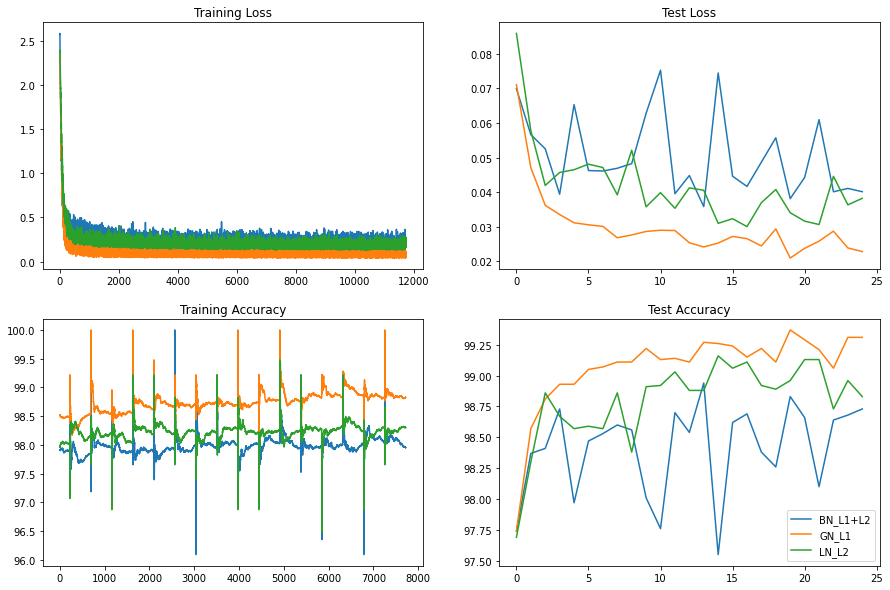

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))


for norm in ['BN', 'GN', 'LN']:
    if norm == 'BN':
        suffix = '_L1+L2'
    elif norm == 'GN':
        suffix = '_L1'
    elif norm == 'LN':
        suffix = '_L2'

    axs[0, 0].plot(train_losses_dict[norm], label = norm +suffix)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc_dict[norm][4000:], label = norm +suffix)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses_dict[norm], label = norm +suffix)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc_dict[norm], label = norm +suffix)
    axs[1, 1].set_title("Test Accuracy")
    plt.legend()

## Function to plot misclassified images

In [43]:
def plot_misclassified_images(img_data, img_name):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  plt.tight_layout()
  plt.savefig(img_name)

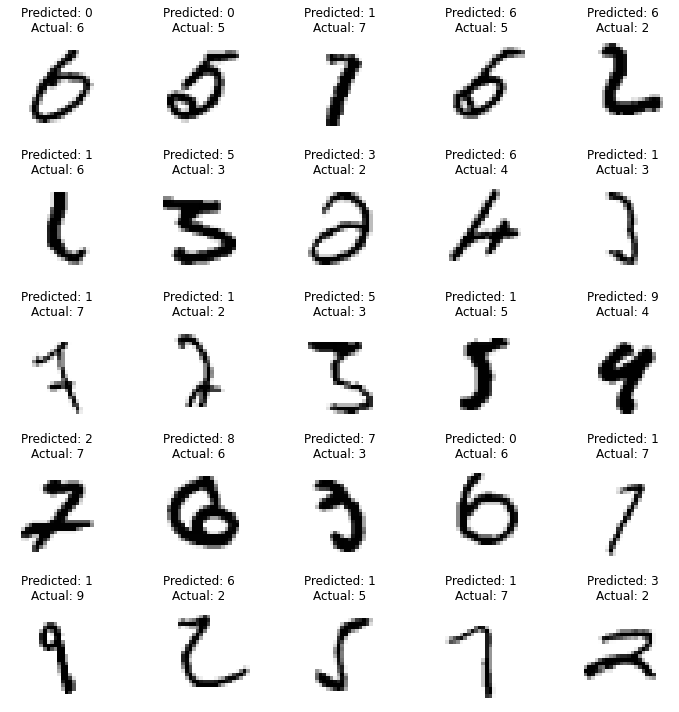

In [44]:
plot_misclassified_images(misclassified_img_dict['BN'],  'BN_L1+L2.png')

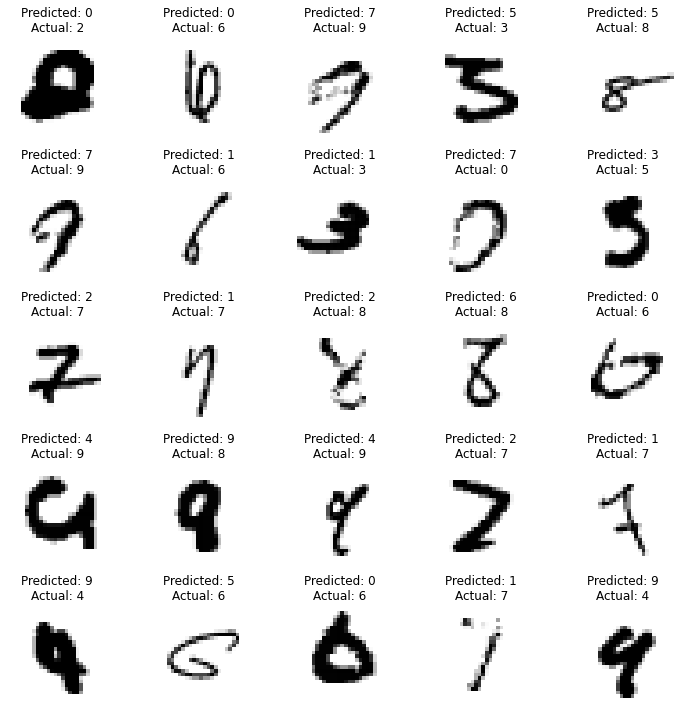

In [45]:
plot_misclassified_images(misclassified_img_dict['GN'],  'GN_L1.png')

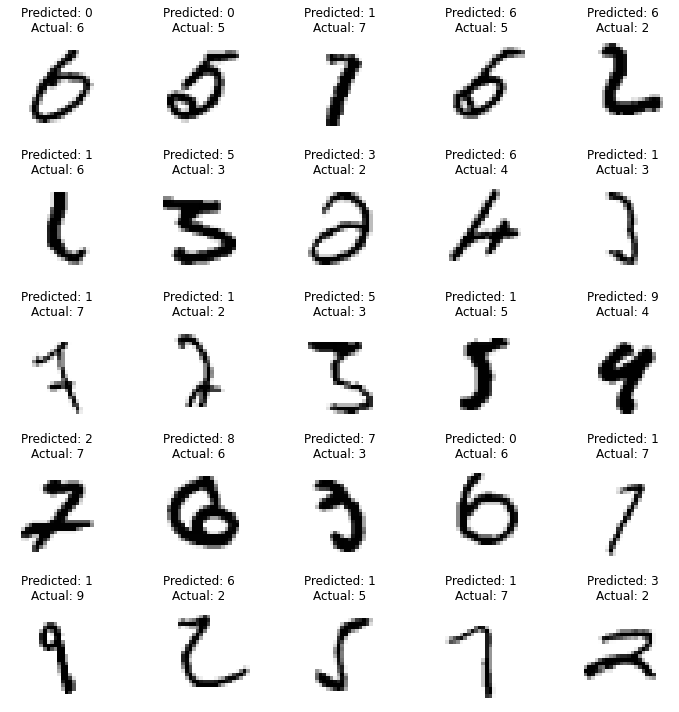

In [46]:
plot_misclassified_images(misclassified_img_dict['BN'],  'LN_L2.png')